In [22]:
import numpy as np
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [23]:
# sns.set()
# plt.figure(figsize=(16,7))

#Read the csv file
df = pd.read_csv('2018-01-01_to_today_hourly_SE2_0314_1557.csv')
cols = df.columns.tolist()
#print(cols)
df = df[['Date','Price', 'WindSpeed', 'AirTemperature', 'Precipitation','weekday','Sunrise','natural_gas_price']]
print(df.head()) #7 columns, including the Date. 

df = df.dropna()

#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])
print(train_dates.tail(15)) #Check last few dates.
print(df.tail(15))



#df['Year'] = df['InsertedDate'].dt.year

df['year'] = train_dates.dt.year #[d.year for d in train_dates.index]
df['month'] = train_dates.dt.month
# df['month'] = train_dates.dt.month_name()

print(df.head())

             Date  Price  WindSpeed  AirTemperature  Precipitation  weekday  \
0  1/1/2018 16:00     26        4.0            -0.3             96        1   
1  1/1/2018 17:00     26        3.0            -0.3             96        1   
2  1/1/2018 18:00     26        3.0            -0.3             97        1   
3  1/1/2018 19:00     26        3.0            -0.3             98        1   
4  1/1/2018 20:00     26        2.0            -0.2             98        1   

   Sunrise  natural_gas_price  
0        0               4.03  
1        0               4.03  
2        0               4.03  
3        0               4.03  
4        0               4.03  
45353   2023-03-10 21:00:00
45354   2023-03-10 22:00:00
45355   2023-03-10 23:00:00
45356   2023-03-11 00:00:00
45357   2023-03-11 01:00:00
45358   2023-03-11 02:00:00
45359   2023-03-11 03:00:00
45360   2023-03-11 04:00:00
45361   2023-03-11 05:00:00
45362   2023-03-11 06:00:00
45363   2023-03-11 07:00:00
45364   2023-03-11 08:00:

<AxesSubplot:xlabel='year', ylabel='Price'>

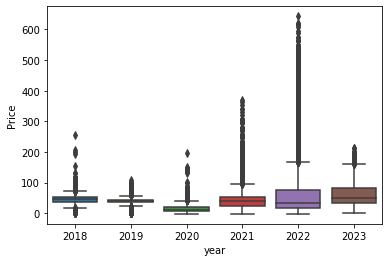

In [24]:
sns.boxplot(x='year', y='Price', data=df)

<AxesSubplot:xlabel='month', ylabel='Price'>

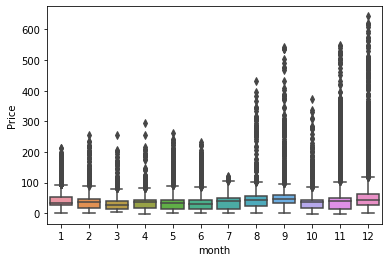

In [25]:
sns.boxplot(x='month', y='Price', data=df)

In [26]:
#Variables for training
cols = list(df)[1:14]
#Date and volume columns are not used in training. 
print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Close']

#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)

# df_for_plot=df_for_training.tail(5000)
# df_for_plot.plot.line()


['Price', 'WindSpeed', 'AirTemperature', 'Precipitation', 'weekday', 'Sunrise', 'natural_gas_price', 'year', 'month']


In [27]:


#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)


In [28]:

#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 23  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

In [29]:
print("df_for_training_scaled")

tmptS = pd.DataFrame(df_for_training_scaled)
tmptS.head(14)





print(df_for_training_scaled[31 - n_past:31, 0:df_for_training.shape[1]])
print(len(df_for_training_scaled))
print(32 - n_past)



df_for_training_scaled
[[-0.40616239 -0.4730906  -0.3782369   1.16287007  0.63295812 -0.48445033
   0.08713388 -1.40736885 -1.52403455]
 [-0.45055223 -0.96012074 -0.3782369   1.16287007  0.63295812 -0.48445033
   0.08713388 -1.40736885 -1.52403455]
 [-0.40616239 -0.96012074 -0.36807181  1.09034187  0.63295812 -0.48445033
   0.08713388 -1.40736885 -1.52403455]
 [-0.40616239 -0.4730906  -0.36807181  1.16287007  0.63295812 -0.48445033
   0.08713388 -1.40736885 -1.52403455]
 [-0.38396747 -0.4730906  -0.36807181  1.16287007  0.63295812 -0.48445033
   0.08713388 -1.40736885 -1.52403455]
 [-0.36177256 -0.4730906  -0.36807181  1.09034187  0.63295812 -0.48445033
   0.08713388 -1.40736885 -1.52403455]
 [-0.33957764 -0.96012074 -0.3782369   1.09034187  0.63295812 -0.48445033
   0.08713388 -1.40736885 -1.52403455]
 [-0.2951878  -0.4730906  -0.38840199  1.01781366  0.63295812 -0.48445033
   0.08713388 -1.40736885 -1.52403455]
 [-0.25079797 -0.96012074 -0.3782369   1.09034187  0.63295812 -0.48445033

In [30]:
print("trainX")

trainX

Output hidden; open in https://colab.research.google.com to view.

In [31]:
print("trainY")
test = pd.DataFrame(trainY)
test.head(30)

trainY


,0
0,-0.117628
1,-0.051044
2,-0.028849
3,-0.117628
4,-0.206408
5,-0.272993
6,-0.317383
7,-0.339578
8,-0.339578
9,-0.361773


In [32]:

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (45345, 23, 9).
trainY shape == (45345, 1).


In [33]:
# define the Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 23, 64)            18944     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 31,393
Trainable params: 31,393
Non-trainable params: 0
_________________________________________________________________


In [34]:
# fit the model
history = model.fit(trainX, trainY, epochs=20, batch_size=16, validation_split=0.1, verbose=1)

# plt.plot(history.history['loss'], label='Training loss')
# plt.plot(history.history['val_loss'], label='Validation loss')
# plt.legend()

Epoch 1/20
2551/2551 [==============================] - 53s 20ms/step - loss: 0.0789 - val_loss: 0.2653
Epoch 2/20
2551/2551 [==============================] - 50s 20ms/step - loss: 0.0361 - val_loss: 0.9352
Epoch 3/20
2551/2551 [==============================] - 50s 19ms/step - loss: 0.0366 - val_loss: 0.2752
Epoch 4/20
2551/2551 [==============================] - 52s 20ms/step - loss: 0.0331 - val_loss: 0.3968
Epoch 5/20
2551/2551 [==============================] - 51s 20ms/step - loss: 0.0329 - val_loss: 0.3131
Epoch 6/20
2551/2551 [==============================] - 50s 20ms/step - loss: 0.0306 - val_loss: 0.2769
Epoch 7/20
2551/2551 [==============================] - 50s 20ms/step - loss: 0.0298 - val_loss: 0.4430
Epoch 8/20
2551/2551 [==============================] - 51s 20ms/step - loss: 0.0298 - val_loss: 0.3104
Epoch 9/20
2551/2551 [==============================] - 49s 19ms/step - loss: 0.0300 - val_loss: 0.3690
Epoch 10/20
2551/2551 [==============================] - 48s 19m

In [35]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

# #Remember that we can only predict one day in future as our model needs 5 variables
# #as inputs for prediction. We only have all 5 variables until the last day in our dataset.
# n_past =23
# n_days_for_prediction=24 #let us predict past 7 days


# predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction).tolist()
# print(predict_period_dates)


In [36]:
# import datetime

# n_past = 23
# n_hours_for_prediction =24  # predict next 24 hours

# last_date = list(train_dates)[-1]  # get last date in train_dates
# predict_period_dates = []
# for i in range(n_hours_for_prediction):
#     next_date = last_date + datetime.timedelta(hours=i+1)  # add 1 hour at a time
#     predict_period_dates.append(next_date)
    
# print(predict_period_dates)

In [37]:
import datetime

n_past = 24
n_hours_for_prediction = 24  # predict next 24 hours

last_date = datetime.datetime(2023, 3, 10)  # set last_date to July 21st, 2022
predict_period_dates = []
j=0
for i in range(n_hours_for_prediction):
    next_date = last_date + datetime.timedelta(hours=i+j)  # add 1 hour at a time
    predict_period_dates.append(next_date)
    j+1
print(predict_period_dates)


[datetime.datetime(2023, 3, 10, 0, 0), datetime.datetime(2023, 3, 10, 1, 0), datetime.datetime(2023, 3, 10, 2, 0), datetime.datetime(2023, 3, 10, 3, 0), datetime.datetime(2023, 3, 10, 4, 0), datetime.datetime(2023, 3, 10, 5, 0), datetime.datetime(2023, 3, 10, 6, 0), datetime.datetime(2023, 3, 10, 7, 0), datetime.datetime(2023, 3, 10, 8, 0), datetime.datetime(2023, 3, 10, 9, 0), datetime.datetime(2023, 3, 10, 10, 0), datetime.datetime(2023, 3, 10, 11, 0), datetime.datetime(2023, 3, 10, 12, 0), datetime.datetime(2023, 3, 10, 13, 0), datetime.datetime(2023, 3, 10, 14, 0), datetime.datetime(2023, 3, 10, 15, 0), datetime.datetime(2023, 3, 10, 16, 0), datetime.datetime(2023, 3, 10, 17, 0), datetime.datetime(2023, 3, 10, 18, 0), datetime.datetime(2023, 3, 10, 19, 0), datetime.datetime(2023, 3, 10, 20, 0), datetime.datetime(2023, 3, 10, 21, 0), datetime.datetime(2023, 3, 10, 22, 0), datetime.datetime(2023, 3, 10, 23, 0)]


In [38]:
prediction = model.predict(trainX[-n_hours_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction
prediction


1/1 [==============================] - 0s 415ms/step


array([[0.783998  ],
       [1.0730224 ],
       [1.040326  ],
       [0.9705187 ],
       [0.8009604 ],
       [0.80500597],
       [0.66889125],
       [0.6374055 ],
       [0.5812378 ],
       [0.571227  ],
       [0.59020936],
       [0.58115894],
       [0.5708626 ],
       [0.8423499 ],
       [0.8015212 ],
       [0.8883176 ],
       [1.0419301 ],
       [1.0189092 ],
       [0.9972669 ],
       [0.97804207],
       [0.88411194],
       [1.0370036 ],
       [1.1930798 ],
       [1.252147  ]], dtype=float32)

In [39]:
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]
y_pred_future

array([77.62311 , 90.6452  , 89.17205 , 86.02686 , 78.38735 , 78.569626,
       72.43693 , 71.018326, 68.48767 , 68.03663 , 68.89189 , 68.484116,
       68.02021 , 80.25217 , 78.41262 , 82.32326 , 89.24432 , 88.207115,
       87.23201 , 86.36583 , 82.13377 , 89.02236 , 96.054436, 98.71572 ],
      dtype=float32)

In [40]:
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
# df_forecast = pd.DataFrame({'predict_period_dates':np.array(forecast_dates), 'electric_price_SE4':y_pred_future})
df_forecast = pd.DataFrame({'predict_period_dates':np.array(predict_period_dates), 'Price':y_pred_future})
df_forecast['predict_period_dates']=pd.to_datetime(df_forecast['predict_period_dates'])
df_forecast

,predict_period_dates,Price
0,2023-03-10 00:00:00,77.623108
1,2023-03-10 01:00:00,90.645203
2,2023-03-10 02:00:00,89.172050
3,2023-03-10 03:00:00,86.026863
4,2023-03-10 04:00:00,78.387352
5,2023-03-10 05:00:00,78.569626
6,2023-03-10 06:00:00,72.436928
7,2023-03-10 07:00:00,71.018326
8,2023-03-10 08:00:00,68.487671
9,2023-03-10 09:00:00,68.036629


In [41]:
plt.figure(figsize=(15,7))
original = df[['Date', 'Price']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2023-03-10']

<ipython-input-41-f512c3c1be88>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])


<Figure size 1080x504 with 0 Axes>

                     Date  Price
45332 2023-03-10 00:00:00     57
45333 2023-03-10 01:00:00     55
45334 2023-03-10 02:00:00     56
45335 2023-03-10 03:00:00     55
45336 2023-03-10 04:00:00     57
45337 2023-03-10 05:00:00     63
45338 2023-03-10 06:00:00     60
45339 2023-03-10 07:00:00     64
45340 2023-03-10 08:00:00     67
45341 2023-03-10 09:00:00     68
45342 2023-03-10 10:00:00     72
45343 2023-03-10 11:00:00     77
45344 2023-03-10 12:00:00     89
45345 2023-03-10 13:00:00     88
45346 2023-03-10 14:00:00     88
45347 2023-03-10 15:00:00     83
45348 2023-03-10 16:00:00     82
45349 2023-03-10 17:00:00     76
45350 2023-03-10 18:00:00     74
45351 2023-03-10 19:00:00     71
45352 2023-03-10 20:00:00     70
45353 2023-03-10 21:00:00     70
45354 2023-03-10 22:00:00     70
45355 2023-03-10 23:00:00     70
45356 2023-03-11 00:00:00     79
45357 2023-03-11 01:00:00     80
45358 2023-03-11 02:00:00     83
45359 2023-03-11 03:00:00     89
45360 2023-03-11 04:00:00     89
45361 2023

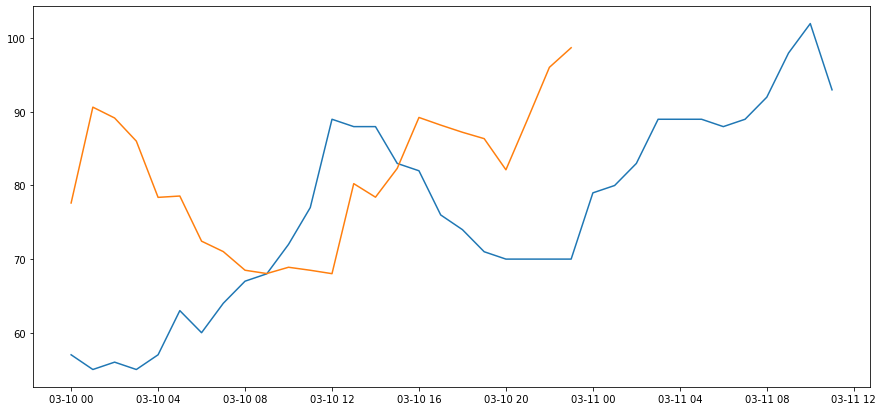

In [42]:
# https://youtu.be/tepxdcepTbY
"""
@author: Sreenivas Bhattiprolu

Code tested on Tensorflow: 2.2.0
    Keras: 2.4.3

dataset: https://finance.yahoo.com/quote/GE/history/
Also try S&P: https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC
"""



#from datetime import datetime





#In my case, trainX has a shape (12809, 14, 5). 
#12809 because we are looking back 14 days (12823 - 14 = 12809). 
#Remember that we cannot look back 14 days until we get to the 15th day. 
#Also, trainY has a shape (12809, 1). Our model only predicts a single value, but 
#it needs multiple variables (5 in my example) to make this prediction. 
#This is why we can only predict a single day after our training, the day after where our data ends.
#To predict more days in future, we need all the 5 variables which we do not have. 
#We need to predict all variables if we want to do that. 






#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).  


#Make prediction

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions



print(original[['Date','Price']])
print(df_forecast[['predict_period_dates','Price']])


# mse = tf.keras.metrics.mean_squared_error(
#     original['electric_price_SE4'][-n_hours_for_prediction:], df_forecast['electric_price_SE4'])


plt.figure(figsize=(15,7))

plt.plot(original['Date'], original['Price'])
plt.plot(df_forecast['predict_period_dates'], df_forecast['Price'])




